GROWTH MODEL FOR TOBACCO USERS
Odalys Benitez and Austin Veseliza



# Question

According to U.S. government data, tobacco consumption is decreasing rapidly from 2000-2015. This behavior is interesting for many reasons, such as the efforts of anti-tobacco propaganda, the variability of price increase in tobacco imports throughout the past, and research claims of increased tobacco dependence with the recent legalization of marijuana. Tobacco consumption could also be a generational trend, in which case it could reach a low point but then rebound as a new generation picks it up. With these factors, it would be interesting to find the best model for the current growth rate of tobacco in the U.S.

#### What is the best-fitting growth model for tobacco's decline since 2000, and what does that model tell us about tobacco's future?

# Model

We based our model on data from the CDC on U.S. tobacco use. The dataset lists the total number of combustible tobacco products (in units of cigarette equivalent) consumed per capita in the U.S. for each year between 2000 and 2015. We designed several growth models to fit this data, including a linear growth model, proportional growth model, piecewise proportional growth model, and quadratic growth model.

### Setting up the environment

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
import matplotlib.pyplot as plt


# import functions from the modsim.py module
from modsim import *

### Importing the data

In [2]:
# The read_csv function converts a csv spreadsheet into a pandas dataframe
from pandas import read_csv

# path to dataset
filename = 'data/Adult_Tobacco_Consumption_In_The_U.S.__2000-Present.csv'
# intake dataset and convert to pandas dataframe
data = read_csv(filename, header=0)
# rows 0 to 15 of dataset contain the data on total combustible tobacco use between 2000-2016
relevant_rows= data[0:16]
# only two columns of the full dataset matter to us: the year and the total tobacco consumption per capita for that year
# extract those two columns from rows 0-15 and store them in relevent_data
relevant_data = relevant_rows[['Year', 'Total Per Capita']]
# relevant_data is currently a dataframe with two columns: year and total_per_capita. The rows are indexed numerically (0-15)
# to make this dataframe into a TimeSeries-like object, convert it to be one column of total_per_capita indexed by year
relevant_data.set_index('Year', inplace=True)
# extract the year indexes from relevant_data for easier access
year = relevant_data.index
# extract the total_per_capita column from relevant_data for easier access
totalpc = relevant_data['Total Per Capita']


Year
2000    2148
2001    2075
2002    2006
2003    1916
2004    1888
2005    1807
2006    1787
2007    1690
2008    1615
2009    1472
2010    1400
2011    1374
2012    1342
2013    1277
2014    1216
2015    1217
Name: Total Per Capita, dtype: int64

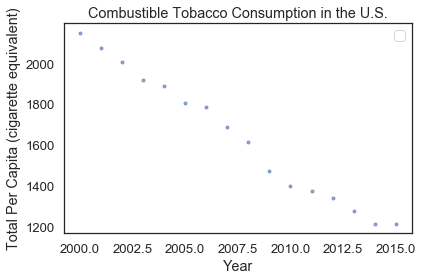

In [3]:
# plot the relevant data
plot(year, totalpc, '.')
decorate(xlabel='Year',
         ylabel='Total Per Capita (cigarette equivalent)',
         title='Combustible Tobacco Consumption in the U.S.')

### Building the model

Our model is designed to have a defined initial state and then iteratively change that state through time according to a chosen growth model. In this case, that initial state is the tobacco consumption rate for the first year we have data: 2000. The chosen growth model dictates how the model will project the tobacco consumption rate for each following year.

The core of this model is the run_simulation function, responsible for generating projections based on an initial state and a growth model.

In [4]:
def run_simulation(system, update_func):
    """Simulate the system based on a growth model.
    
    system: System object
        expected to contain
            - t_0: the first year for which we have data
            - v_0: the value of the first year's data
            - proj_end: the year to which the model should project
    
    update_func: function that computes tobacco consumption per capita next year (growth model)
        expected to accept
            - numeric value (this year's tobacco consumption per capita in units cigarette equivalent)
            - year (next year)
            - System object (system)
        expected to return
            - numeric value (next year's tobacco consumption per capita in units cigarette equivalent)
    
    returns: TimeSeries
    """
    # initialize TimeSeries to store results for each year as they're generated
    results = TimeSeries()
    # store first year's data in results, setting it as the initial state on which the model will iterate
    results[system.t_0] = system.v_0
    
    # run this code for every year between the starting year and the year the model should project to
    for t in linrange(system.t_0, system.proj_end):
        # Give the growth model this year's tobacco consumption rate and find out what it thinks next year's rate will be
        # Store next year's consumption rate in the results
        results[t+1] = update_func(results[t], t, system)
    
    # return a TimeSeries containing the model's projected tobacco consumption rate for each year in the specified range
    return results

As detailed above, the run_simulation function expects a System object with some information about the model's initial state and expectations for how far it should project into the future. Here we create that System object:

In [5]:
# gather the first and last years for which we have data
t_0 = get_first_label(relevant_data)
t_end = get_last_label(relevant_data)

# gather the tobacco consumption rates for those two years
v_0 = get_first_value(relevant_data)
v_end = get_last_value(relevant_data)

# initialize a System object that contains all those values
system = System(
    t_0 = t_0,
    t_end = t_end,
    v_0 = v_0,
    v_end = v_end,
    # by default, set the final year the model should project to as the last year we have data for
    # this is useful for fine-tuning growth model parameters so they best fit the data
    proj_end = t_end
)

# NOTE: t_end and v_end are not called for in run_simulation, but they become useful later

,values
t_0,2000
t_end,2015
v_0,[2148]
v_end,[1217]
proj_end,2015


The other thing the run_simulation function expects is an update function. How this function determines next year's tobacco consumption rate from the last defines the model's "growth model." Below are several update functions, each corresponding to a different growth model:

In [6]:
def linear_update_func(curr_tobacco, t, system):
    """ Update function for linear growth model
    
    curr_tobacco: this year's tobacco consumption per capita in units cigarette equivalent

    t: this year
    
    system: System object
        expected to contain
            - annual_growth: the average annual growth rate of tobacco consumption based on the data
    """
    
    # add annual growth rate to current tobacco consumption to get next year's tobacco consumption
    return curr_tobacco + system.annual_growth

In [7]:
def proportional_update_func(curr_tobacco, t, system):
    """ Update function for proportional growth model
    
    curr_tobacco: this year's tobacco consumption per capita in units cigarette equivalent

    t: this year
    
    system: System object
        expected to contain
            - prop_alpha: alpha value for proportional growth / value by which current tobacco consumption will be multiplied
    """
    
    net_growth = system.prop_alpha * curr_tobacco
    
    return curr_tobacco + net_growth
    

In [8]:
def piecewise_proportional_update_func(curr_tobacco, t, system):
    """ Update function for peicewise proportional growth model
    
    curr_tobacco: this year's tobacco consumption per capita in units cigarette equivalent

    t: this year
    
    system: System object
        expected to contain
            - prop_alpha1: alpha value for proportional growth before 2008
            - prop_alpha2: alpha value for proportional growth during 2008 and 2009
            - prop_alpha3: alpha value for proportional growth after 2009
    """
    
    if (t <= 2007):
        net_growth = system.prop_alpha1  * curr_tobacco
    if (t > 2007 and t < 2010):
        net_growth = system.prop_alpha2 * curr_tobacco
    if (t > 2009):
        net_growth = system.prop_alpha3 * curr_tobacco
    
        
    return curr_tobacco + net_growth

In [9]:
def quadratic_update_func(curr_tobacco, t, system):
    """ Update function for quadratic growth model
    
    curr_tobacco: this year's tobacco consumption per capita in units cigarette equivalent

    t: this year
    
    system: System object
        expected to contain
            - quad_alpha: alpha value for quadratic growth
            - quad_beta: beta value for quadratic growth
    """
    
    net_growth = system.quad_alpha * curr_tobacco + system.quad_beta * curr_tobacco**2
    
    return curr_tobacco + net_growth

# Results

### Matching the data
The below figures demonstrate how well each growth model matches the real decline in tobacco consumption in the U.S.:

#### Linear Growth Model

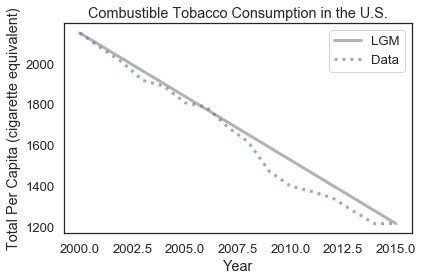

In [10]:
# set expected parameters in System object for update function
# use data stored in system to compute average annual growth rate based on dataset
elapsed_time = system.t_end - system.t_0
total_growth = system.v_end - system.v_0
system.annual_growth = total_growth / elapsed_time

# simulate the model using the initial state in system and the given growth model
results = run_simulation(system, linear_update_func)

# plot the results
plot(results, color='gray', label='LGM')
plot(year, totalpc, ':', label='Data')
decorate(xlabel='Year', 
         ylabel='Total Per Capita (cigarette equivalent)',
         title='Combustible Tobacco Consumption in the U.S.')

#### Proportional Growth Model

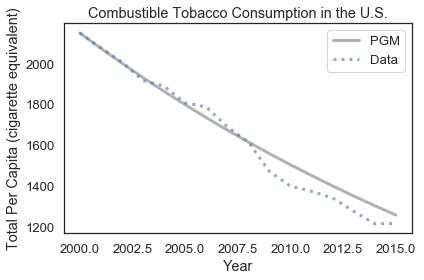

In [11]:
# set expected parameters in System object for update function
system.prop_alpha = -0.035

# simulate the model using the initial state in system and the given growth model
results = run_simulation(system, proportional_update_func)

# plot the results
plot(results, color='gray', label='PGM')
plot(year, totalpc, ':', label='Data')
decorate(xlabel='Year', 
         ylabel='Total Per Capita (cigarette equivalent)',
         title='Combustible Tobacco Consumption in the U.S.')

#### Piecewise Proportional Growth Model

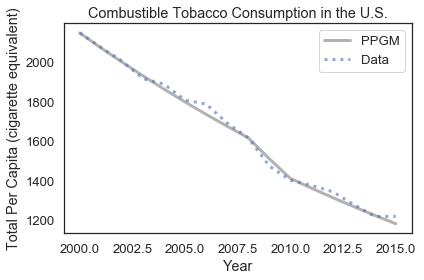

In [12]:
# set expected parameters in System object for update function
system.prop_alpha1 = -0.035
system.prop_alpha2 = -0.066
system.prop_alpha3 = -0.035

# simulate the model using the initial state in system and the given growth model
results = run_simulation(system, piecewise_proportional_update_func)

# plot the results
plot(results, color='gray', label='PPGM')
plot(year, totalpc, ':', label='Data')
decorate(xlabel='Year', 
         ylabel='Total Per Capita (cigarette equivalent)',
         title='Combustible Tobacco Consumption in the U.S.')

#### Quadratic Growth Model

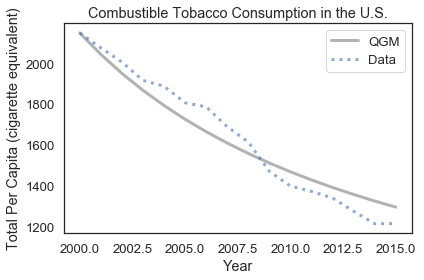

In [13]:
# set expected parameters in System object for update function
system.quad_alpha = 0.02
system.quad_beta = -0.000032

# simulate the model using the initial state in system and the given growth model
results = run_simulation(system, quadratic_update_func)

# plot the results
plot(results, color='gray', label='QGM')
plot(year, totalpc, ':', label='Data')
decorate(xlabel='Year', 
         ylabel='Total Per Capita (cigarette equivalent)',
         title='Combustible Tobacco Consumption in the U.S.')

### Projecting future trends
The below figures show projections from each growth model on how tobacco consumption will continue to decline in the future. Each figure shows either the year that model projects tobacco consumption will end or the minimum consumption rate it will approach over time.

#### Linear Growth Model
According to this model, combustible tobacco will stop being consumed in the U.S. by approximately 2035.

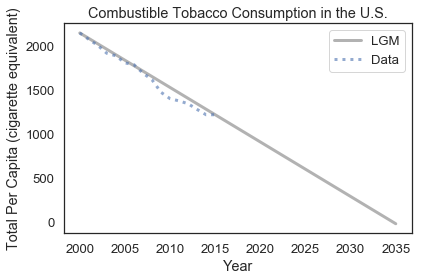

In [14]:
# set year the model should project to
system.proj_end = 2035

# simulate the model up to the projection year using the initial state in system and the given growth model
results = run_simulation(system, linear_update_func)

# plot the results
plot(results, color='gray', label='LGM')
plot(year, totalpc, ':', label='Data')
decorate(xlabel='Year', 
         ylabel='Total Per Capita (cigarette equivalent)',
         title='Combustible Tobacco Consumption in the U.S.')

#### Proportional Growth Model
According to this model, combustible tobacco consumption will almost completely cease in the U.S. by approximately 2150.

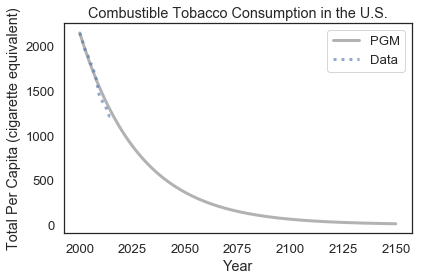

In [15]:
# set year the model should project to
system.proj_end = 2150

# simulate the model up to the projection year using the initial state in system and the given growth model
results = run_simulation(system, proportional_update_func)

# plot the results
plot(results, color='gray', label='PGM')
plot(year, totalpc, ':', label='Data')
decorate(xlabel='Year', 
         ylabel='Total Per Capita (cigarette equivalent)',
         title='Combustible Tobacco Consumption in the U.S.')

#### Piecewise Proportional Growth Model
According to this model, combustible tobacco consumption will almost completely cease in the U.S. by approximately 2150.

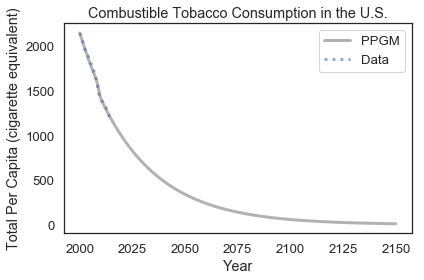

In [16]:
# set year the model should project to
system.proj_end = 2150

# simulate the model up to the projection year using the initial state in system and the given growth model
results = run_simulation(system, piecewise_proportional_update_func)

# plot the results
plot(results, color='gray', label='PPGM')
plot(year, totalpc, ':', label='Data')
decorate(xlabel='Year', 
         ylabel='Total Per Capita (cigarette equivalent)',
         title='Combustible Tobacco Consumption in the U.S.')

#### Quadratic Growth Model
According to this model, tobacco consumption in the U.S. will slowly descend to approximately 620 cigarette equivalents per capita per year but will not go lower.

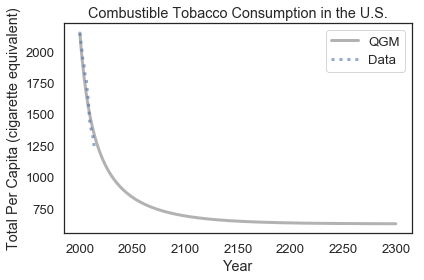

In [17]:
# set year the model should project to
system.proj_end = 2300

# simulate the model up to the projection year using the initial state in system and the given growth model
results = run_simulation(system, quadratic_update_func)

# plot the results
plot(results, color='gray', label='QGM')
plot(year, totalpc, ':', label='Data')
decorate(xlabel='Year', 
         ylabel='Total Per Capita (cigarette equivalent)',
         title='Combustible Tobacco Consumption in the U.S.')

# Interpretation

The majority of the models fit the data well to a certain extent. The constant growth model follows the general pattern of the line, but cannot predict the numerical values accurately from year to year. Between the pure proportional and piecewise proportional model, there's no doubt that the piecewise proportional model fits the data better. Though piecewise growth models can be the result of over-fitting to data and tend to lack predictive power, the fact that the pre-2008-2009 growth rate exactly equals the post-2008-2009 growth rate suggests this model has a degree of predictive accuracy. This indicates the piecewise proportional model is picking up on a larger, consistent trend in tobacco use, in which case the temporary change in growth rate during 2008 and 2009 is likely the result of an outside factor which could be further investigated. The quadratic growth model also mainly follows the general pattern of the line, but it's difficult to say whether that model actually fits this data without some real world indication that tobacco use is approaching a minimum rate rather than dying off completely. There may also be some useful information in the constants chosen to fit each model to the data, though determining that would require more rigorous mathematical analysis.

The biggest implications of these growth models are their projections for tobacco use going forward. The most seemingly accurate (or at least most optimistic) would be the linear projection, which projects that combustible tobacco consumption will cease in the U.S. by around 2035. Based on our perception of how cigarette smoking has changed in the U.S. over our lifetimes, 2035 seems like an only slightly premature estimate for when the trend will die out. This claim would be easier to verify if we had even a few datapoints from the height of tobacco consumption.

Future work includes finding more models and implementing different triggers to change the way model behaves in accordance to events in our society that can affect tobacco popularity. Our current models cannot predict how the prevalence of other drugs may affect tobacco, nor how legislation and public policy around tobacco will evolve in the future. All of these are important factors for accurately modelling tobacco's decline in the U.S.

It is important to model tobacco consumption because of the harmful effects on our environment, and the tax contribution to our economy.

# Sources
Adult Tobacco Consumption in the U.S., 2000-Present
https://catalog.data.gov/dataset/adult-tobacco-consumption-in-the-u-s-2000-present

Tobacco dependence increases with marijuana legalization
https://www.mdvip.com/about-mdvip/blog/tobacco-use-rise-marijuana-legalized

Tobacco has harmful effects on our environment 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2697937/ 

Different factors that control tobacco purchases
http://www.who.int/tobacco/economics/2_1ffactorsaffectingconsumerbehavior.pdf 